# This is Cartography put together into one place. 

## Modules to add to run this code:

- [BioPython][1]
- [Pandas][2]
- [Numpy][3]
- [Altair][4]
- [Seaborn][5]
- [Scikit-Learn][6]
- [UMAP][7]
- json
- nextstrain-augur
- statsmodels
[1]:https://biopython.org/wiki/Download
[2]:https://pandas.pydata.org/pandas-docs/version/0.23.3/install.html
[3]:https://docs.scipy.org/doc/numpy/user/quickstart.html
[4]:https://altair-viz.github.io/getting_started/installation.html
[5]:https://seaborn.pydata.org/installing.html
[6]:https://scikit-learn.org/stable/install.html
[7]:https://umap-learn.readthedocs.io/en/latest/


# Massive to-do: remove ALL code that scripts are doing for you. 
- finish KDS plot script
- push everything to github
- fix snakemake input/output to names instead of values
- delete everything that isn't visualization (and creating the tree, merging)

# Imports Section 

In [1]:
import pandas as pd
import altair as alt
import numpy as np
from scipy.spatial.distance import squareform, pdist
from Bio import SeqIO
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from augur.utils import json_to_tree
import json
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import umap
from scipy.stats import linregress
from pathlib import Path
import statsmodels
import statistics
import matplotlib.pyplot as plt
from Helpers import get_euclidean_data_frame, get_hamming_distances, linking_tree_with_plots_brush
from Helpers import linking_tree_with_plots_clickable
from Helpers import scatterplot_xyvalues, scatterplot_tooltips, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions
#import selenium
#from selenium.webdriver import Chrome 
#from svglib.svglib import svg2rlg
#from reportlab.graphics import renderPDF
from Helpers import get_y_positions
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [ ]:
from selenium import webdriver

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("--remote-debugging-port=9222")

browser = webdriver.Chrome(options=chrome_options)

## Pathogen-specific variables

Consider consolidating these into a single configuration file that can be passed to the notebook as a command line argument for more scriptable generation of these figures.

# Flu Specific Variables

### Old Flu Files

In [3]:
path = "../seasonal-flu-nextstrain/results-20182020/variable_sites.fasta"
dropped_strains = []
tree_path = "../seasonal-flu-nextstrain/auspice-20182020/flu_seasonal_h3n2_ha_2y.json"
virus_name = "Flu"
clades_to_plot = ['3c3.A', 'A3', 'A2/re', 'A2', 'A1b/135N', 'A1b/131K', 'A1b/94N', 'A1b/131K', 'A1b/197R', 'A1b/135K', 'A1b/137F', 'A1b/186D']

# Zika Specific Variables 

In [ ]:
path = "../zika-nextstrain/results-20182020/variable_sites.fasta"
dropped_strains = ["Yunnan/01/2019"]
distance_matrix_file = "DistanceMatrixZika.csv"
tree_path = '../zika-nextstrain/auspice-20182020/zika-cartography_tree.json'
virus_name = "Zika"
clades_to_plot = None

### Reading in the Fasta File
- I used BioPython to parse the Fasta file into two numpy Arrays: Genomes and Strains. 

In [4]:
#work on making this work
strains = []
genomes = []
for record in SeqIO.parse(path, "fasta"):
    if(record.id not in dropped_strains):
        strains.append(str(record.id))
        genomes.append(str(record.seq))

In [5]:
#### Checking to make sure the file I picked is a aligned Fasta file / is the file I wanted

len(strains)
print(len(genomes[0]) == len(genomes[1]))
print(len(genomes))

True
709


In [6]:
strains[:5]

['U26830.1',
 'A/Alabama/30/2017',
 'A/Florida/84/2017',
 'A/NorthDakota/23/2017',
 'A/Florida/18/2018']

In [7]:
genomes_df = pd.DataFrame(genomes)
strains_df = pd.DataFrame(strains)

In [8]:
strains_df.columns = ["strain"]
strains_df

,strain
0,U26830.1
1,A/Alabama/30/2017
2,A/Florida/84/2017
3,A/NorthDakota/23/2017
4,A/Florida/18/2018
...,...
704,A/Ohio/08/2019
705,A/Florida/78/2019
706,A/California/16/2020
707,A/Minnesota/40/2018


In [9]:
genomes_missing_bases = []
for x in genomes:
    x = re.sub(r'[^AGCT]', '5', x)
    numberOfN = x.count("5")
    genomes_missing_bases.append(numberOfN)

In [10]:
genomes_missing_bases_df = pd.DataFrame(genomes_missing_bases)
genomes_missing_bases_df = genomes_missing_bases_df.merge(strains_df, how='outer', left_index = True, right_index = True)
genomes_missing_bases_df.columns = ["bases missing", "strain"]

In [11]:
# Missing Bases

genomes_missing_bases_df.head()

,bases missing,strain
0,0,U26830.1
1,1,A/Alabama/30/2017
2,0,A/Florida/84/2017
3,0,A/NorthDakota/23/2017
4,0,A/Florida/18/2018


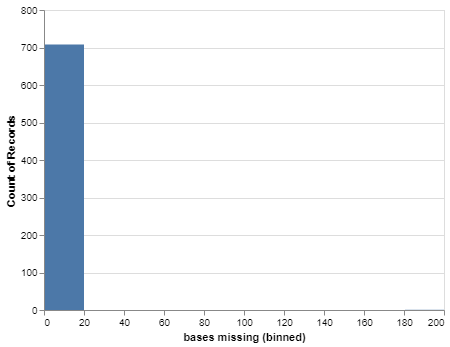

In [12]:
alt.Chart(genomes_missing_bases_df).mark_bar().encode(
    alt.X("bases missing:Q", bin=True),
    y="count()"
)

In [13]:
# Also, consider storing the list of dropped strains in a text file outside of the notebook.
dropped_strains.extend(list(genomes_missing_bases_df[genomes_missing_bases_df["bases missing"]>1000]["strain"]))

In [14]:
len(dropped_strains)

0

In [15]:
dropped_strains = pd.Series(dropped_strains) 
indexNames = dropped_strains.isin(['strain']).index
strains_df.drop(indexNames , inplace=True)
strains_df.reset_index(drop = True)

C:\Work\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


,strain
0,U26830.1
1,A/Alabama/30/2017
2,A/Florida/84/2017
3,A/NorthDakota/23/2017
4,A/Florida/18/2018
...,...
704,A/Ohio/08/2019
705,A/Florida/78/2019
706,A/California/16/2020
707,A/Minnesota/40/2018


In [16]:
genomes_df.drop(indexNames , inplace=True)
genomes_df.columns = ["strain"]
genomes_df.reset_index(drop = True)

,strain
0,GACTTCTTGATAATTGTCTGGTTTTCGTCAAACTTCGGAAATGCAC...
1,GACTTCTTGATAATCGCCTGGTTTTCGTCAAAATTTGGAAATGCAT...
2,GACTTCTTGATAATCGCCTGGTTTTCGTCAAAATTTGGAAATGCAT...
3,GACTTCTTGATAATCGCCTGGTTTTCGTCAAAATTTGGAAATGCAT...
4,GACTTCTTGATAATCGTCTGGTTTTCGTCAAAATTTGGAAATGCAT...
...,...
704,GACTTCTTGATGATCGTCTGGTTTTCGTCAAAATTTGGAAATGCAT...
705,GACTTCTTGATGATCGTCTGGTTTTCGTCAAAATTTGGAAATGCAT...
706,GACTTCTTGATGATCGTCTGGTTTTCGTCAAAATTTGGAAATGCAT...
707,GACTTCTTGATGATCGTCTGGTTTTCGTCAAAATTTAGAAATGCAT...


In [17]:
genomes = genomes_df["strain"].values.tolist()

strains = strains_df["strain"].values.tolist()

# Creating the Distance Matrix
- I used Hamming Distance to find the pairwise distance between each genome and each other genome, effectively creating a similarity/distance matrix
    - In my Hamming Distance method, I only counted something as a different if it was a mismatch between the nucleotides (A,G,C, or T), not gaps (as that was throwing off the algorithm too much for smaller strains)
- I then used Seaborn to generate a heatmap to make sure the matrix looked correct

In [18]:
%%time
# Try to load an existing distance matrix. Create it, if it doesn't already exist.
"""try:
    # The index should be the first column and correspond to strain name for the row.
    similarity_matrix = pd.read_csv(distance_matrix_file, index_col=0)
    print("Loaded existing distance matrix")
except FileNotFoundError:
    print("Could not find existing distance matrix, creating it now", end="...")
"""    
# Calculate Hamming distances.
hamming_distances = get_hamming_distances(genomes)

# Convert distinct pairwise distances into the more redundant but more interpretable square matrix.
similarity_matrix = squareform(hamming_distances)

# Convert the numpy matrix to a pandas data frame with strain annotations for rows and columns.
similarity_matrix = pd.DataFrame(
    similarity_matrix,
    columns=strains,
    index=strains
)

# Write out the resulting data frame to cache distance calculations.
# Keep the index in the output file, so it is immediately available on read.
#similarity_matrix.to_csv(distance_matrix_file)
print("done!")

done!
Wall time: 2.67 s


In [19]:
similarity_matrix

,U26830.1,A/Alabama/30/2017,A/Florida/84/2017,A/NorthDakota/23/2017,A/Florida/18/2018,A/Indiana/31/2017,A/SouthAustralia/13/2018,A/Sydney/25/2018,A/Newcastle/21/2018,A/Sydney/55/2018,...,A/Georgia/06/2019,A/Idaho/11/2019,A/Michigan/381/2019,A/Hawaii/48/2019,A/Hawaii/41/2019,A/Ohio/08/2019,A/Florida/78/2019,A/California/16/2020,A/Minnesota/40/2018,A/Oklahoma/11/2018
U26830.1,0,164,164,164,163,164,164,167,166,165,...,166,166,167,169,166,169,166,168,164,167
A/Alabama/30/2017,164,0,2,2,7,7,8,9,8,7,...,62,61,62,66,63,62,63,67,54,57
A/Florida/84/2017,164,2,0,2,7,8,8,9,8,7,...,62,61,62,66,63,62,63,67,54,57
A/NorthDakota/23/2017,164,2,2,0,7,8,8,9,8,7,...,62,61,62,66,63,62,63,67,54,57
A/Florida/18/2018,163,7,7,7,0,7,7,8,7,6,...,62,61,62,66,61,62,61,67,54,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A/Ohio/08/2019,169,62,62,62,62,63,61,64,63,62,...,6,6,6,10,9,0,11,13,29,32
A/Florida/78/2019,166,63,63,63,61,64,62,65,64,63,...,9,9,9,13,8,11,0,18,30,33
A/California/16/2020,168,67,67,67,67,68,66,69,68,67,...,13,13,13,17,16,13,18,0,32,35
A/Minnesota/40/2018,164,54,54,54,54,55,51,54,55,54,...,27,27,27,31,28,29,30,32,0,5


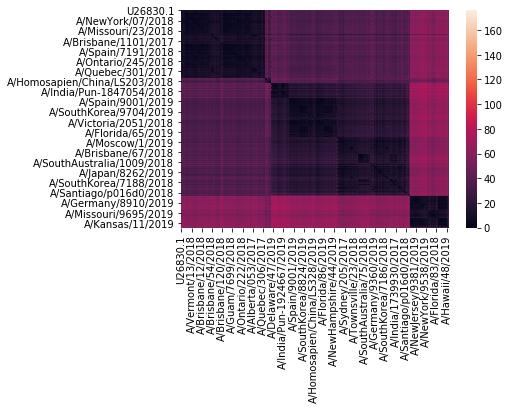

In [20]:
sns.heatmap(similarity_matrix)

# Creating the Phylogenetic Tree in Altair
- I used Altair to make this tree (Documentation linked [here][1]
- The data from the JSON and the Data from the tree are usually a little different, so after merging the two dataframes you may get some errors.

[1]: https://altair-viz.github.io/index.html

In [21]:
with open(tree_path) as fh:
    json_tree_handle = json.load(fh)

In [22]:
tree = json_to_tree(json_tree_handle)

In [23]:
tree

Clade(branch_length=0, name='NODE_0000000')

In [24]:
heights = get_y_positions(tree)
for node in tree.find_clades():
    node.yvalue = heights[node]

In [25]:
node_data = [
    {
        "strain": node.name,
        "date": node.node_attrs["num_date"]["value"],
        "y": node.yvalue,
        "region": node.node_attrs["region"]["value"],
        "country": node.node_attrs["country"]["value"],
        "parent_date": node.parent is not None and node.parent.node_attrs["num_date"]["value"] or node.node_attrs["num_date"],
        "parent_y": node.parent is not None and node.parent.yvalue or node.yvalue,
        "clade_membership" : node.node_attrs['clade_membership']["value"]
    }
    for node in tree.find_clades(terminal=True)
]

In [26]:
node_data[10]

{'strain': 'A/Germany/7354/2018',
 'date': 2018.1986301369864,
 'y': 11,
 'region': 'N',
 'country': 'Germany',
 'parent_date': 2018.0403714864015,
 'parent_y': 11.9375,
 'clade_membership': '3c3.A'}

In [27]:
node_df = pd.DataFrame(node_data)

In [28]:
node_df.head()

,strain,date,y,region,country,parent_date,parent_y,clade_membership
0,A/Minnesota/40/2018,2018.543836,1,N,USA,2017.963472,1.500000,3c3.A
1,A/Oklahoma/11/2018,2018.113699,2,N,USA,2017.963472,1.500000,3c3.A
2,A/Ohio/23/2018,2018.524658,3,N,USA,2018.046293,3.500000,3c3.A
3,A/Florida/83/2018,2018.675342,4,N,USA,2018.046293,3.500000,3c3.A
4,A/England/7208/2018,2018.256164,5,N,United Kingdom,2017.854815,7.106453,3c3.A


In [29]:
node_df["y"] = node_df["y"].max() - node_df["y"]

In [30]:
node_df["parent_y"] = node_df["parent_y"].max() - node_df["parent_y"]

In [31]:
node_df.shape

(707, 8)

In [32]:
node_df.head()

,strain,date,y,region,country,parent_date,parent_y,clade_membership
0,A/Minnesota/40/2018,2018.543836,706,N,USA,2017.963472,705.000000,3c3.A
1,A/Oklahoma/11/2018,2018.113699,705,N,USA,2017.963472,705.000000,3c3.A
2,A/Ohio/23/2018,2018.524658,704,N,USA,2018.046293,703.000000,3c3.A
3,A/Florida/83/2018,2018.675342,703,N,USA,2018.046293,703.000000,3c3.A
4,A/England/7208/2018,2018.256164,702,N,United Kingdom,2017.854815,699.393547,3c3.A


In [33]:
node_df["region"].unique()

array(['N', 'S', 'T'], dtype=object)

In [34]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

In [35]:
indices_to_drop = similarity_matrix[~similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix[similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix.drop(indices_to_drop.index, axis=1)
similarity_matrix

,A/Alabama/30/2017,A/Florida/84/2017,A/NorthDakota/23/2017,A/Florida/18/2018,A/Indiana/31/2017,A/SouthAustralia/13/2018,A/Sydney/25/2018,A/Newcastle/21/2018,A/Sydney/55/2018,A/Sydney/93/2018,...,A/Georgia/06/2019,A/Idaho/11/2019,A/Michigan/381/2019,A/Hawaii/48/2019,A/Hawaii/41/2019,A/Ohio/08/2019,A/Florida/78/2019,A/California/16/2020,A/Minnesota/40/2018,A/Oklahoma/11/2018
A/Alabama/30/2017,0,2,2,7,7,8,9,8,7,9,...,62,61,62,66,63,62,63,67,54,57
A/Florida/84/2017,2,0,2,7,8,8,9,8,7,9,...,62,61,62,66,63,62,63,67,54,57
A/NorthDakota/23/2017,2,2,0,7,8,8,9,8,7,9,...,62,61,62,66,63,62,63,67,54,57
A/Florida/18/2018,7,7,7,0,7,7,8,7,6,8,...,62,61,62,66,61,62,61,67,54,57
A/Indiana/31/2017,7,8,8,7,0,8,9,8,7,9,...,63,62,63,67,64,63,64,68,55,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A/Ohio/08/2019,62,62,62,62,63,61,64,63,62,64,...,6,6,6,10,9,0,11,13,29,32
A/Florida/78/2019,63,63,63,61,64,62,65,64,63,65,...,9,9,9,13,8,11,0,18,30,33
A/California/16/2020,67,67,67,67,68,66,69,68,67,69,...,13,13,13,17,16,13,18,0,32,35
A/Minnesota/40/2018,54,54,54,54,55,51,54,55,54,56,...,27,27,27,31,28,29,30,32,0,5


In [36]:
node_df

,strain,date,y,region,country,parent_date,parent_y,clade_membership,clade_membership_color
0,A/Minnesota/40/2018,2018.543836,706,N,USA,2017.963472,705.000000,3c3.A,3c3.A
1,A/Oklahoma/11/2018,2018.113699,705,N,USA,2017.963472,705.000000,3c3.A,3c3.A
2,A/Ohio/23/2018,2018.524658,704,N,USA,2018.046293,703.000000,3c3.A,3c3.A
3,A/Florida/83/2018,2018.675342,703,N,USA,2018.046293,703.000000,3c3.A,3c3.A
4,A/England/7208/2018,2018.256164,702,N,United Kingdom,2017.854815,699.393547,3c3.A,3c3.A
...,...,...,...,...,...,...,...,...,...
702,A/Washington/9847/2019,2019.604110,4,N,USA,2019.445500,2.562500,A1b/197R,A1b/197R
703,A/Idaho/43/2019,2019.916438,3,N,USA,2019.515818,1.625000,A1b/197R,A1b/197R
704,A/Montana/55/2019,2019.867123,2,N,USA,2019.563924,0.750000,A1b/197R,A1b/197R
705,A/Connecticut/43/2019,2019.982192,1,N,USA,2019.620548,0.000000,A1b/197R,A1b/197R


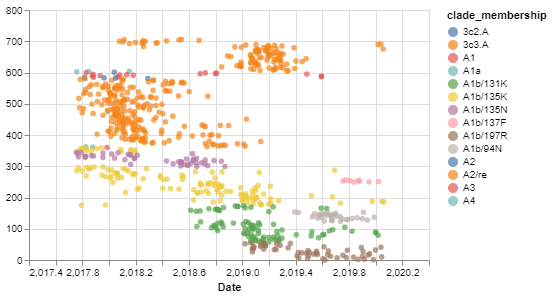

In [37]:
base = alt.Chart(node_df)
brush = alt.selection(type='interval', resolve='global')
base.mark_circle().encode(
    x=alt.X(
        "date:Q",
        scale=alt.Scale(
            domain=(node_df["date"].min() - 0.2, node_df["date"].max() + 0.2)),
        title="Date"
    ),
    y=alt.Y(
        "y:Q",
        title=""
    ),
    color=alt.condition(brush, "clade_membership", alt.ColorValue('gray')),
).add_selection(brush).properties(width=400, height=250)

## Checking for Outliers in Pairwise Distance

In [ ]:
mean_distances = similarity_matrix.mean().reset_index(name="mean_distance").rename(columns={"index": "strain"})

In [ ]:
mean_distances.head()

In [ ]:
alt.Chart(mean_distances, height=150).mark_boxplot().encode(
    x = alt.X('mean_distance', title="mean of pairwise distances"),
    tooltip = ["strain"]
)

In [ ]:
# Checks for outliers - makes sure most outliers are from the same clade
query_df = pd.DataFrame(mean_distances.query("mean_distance>45")["strain"].drop_duplicates())

query_df = query_df.merge(genomes_missing_bases_df, how="inner", on="strain")
query_df = query_df.merge(node_df, how = "inner", on="strain")
query_df["clade_membership"].unique()

# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [ ]:
numbers = genomes[:]
for i in range(0,len(genomes)):
    numbers[i] = re.sub(r'[^AGCT]', '5', numbers[i])
    numbers[i] = list(numbers[i].replace('A','1').replace('G','2').replace('C', '3').replace('T','4'))
    numbers[i] = [int(j) for j in numbers[i]]
genomes_df = pd.DataFrame(numbers)
genomes_df.columns = ["Site " + str(k) for k in range(0,len(numbers[i]))]

In [ ]:
genomes_df.head()

In [ ]:
#performing PCA on my pandas dataframe 
pca = PCA(n_components=10,svd_solver='full') #can specify n, since with no prior knowledge, I use None
principalComponents = pca.fit_transform(genomes_df)

In [ ]:
# Create a data frame from the PCA embedding.
principalDf = pd.DataFrame(data = principalComponents, columns = ["PCA" + str(i) for i in range(1,11)])

# Annotate rows by their original strain names. PCA rows are in the same order as
# the `genomes` rows which are in the same order as the `strains` rows.
principalDf["strain"] = strains

In [ ]:
df = pd.concat([pd.DataFrame(np.arange(1,11)), pd.DataFrame([round(pca.explained_variance_ratio_[i],4) for i in range(0,len(pca.explained_variance_ratio_))])], axis = 1)
df.columns = ['principal components','explained variance']
df

In [ ]:
chart = alt.Chart(df).mark_line().encode(
    x='principal components:Q',
    y='explained variance:Q'
)
chart
chart.save("explainedvariance" + virus_name + ".png")

In [ ]:
merged_pca_df = principalDf.merge(node_df, on="strain")

In [ ]:
merged_pca_df.head()

In [ ]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['PCA1','PCA2','PCA3','PCA4', 'PCA5', 'PCA6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(pca.explained_variance_ratio_[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(pca.explained_variance_ratio_[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(pca.explained_variance_ratio_[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(pca.explained_variance_ratio_[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(pca.explained_variance_ratio_[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(pca.explained_variance_ratio_[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain','region'])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

In [ ]:
PCA_violin_df = get_euclidean_data_frame(merged_pca_df, "PCA1", "PCA2", "PCA")
g = sns.FacetGrid(
    PCA_violin_df,
    col="embedding",
    col_wrap=3,
    sharey=False,
    height=4
)
g = g.map(sns.violinplot, "clade_status", "distance", order=["within", "between"])
g.set_axis_labels("Clade status", "Distance")
plt.savefig("docs/PCAViolinPlot" + virus_name + ".png")

In [ ]:
total_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_pca_df, "PCA1", "PCA2", "PCA")
y_values = statsmodels.nonparametric.smoothers_lowess.lowess(
    total_df["euclidean"],
    total_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

PD_Y_values = pd.DataFrame(y_values)
PD_Y_values.columns = ["LOWESS_x", "LOWESS_y"]

In [ ]:

regression = linregress(total_df["genetic"], total_df["euclidean"])
slope, intercept, r_value, p_value, std_err = regression

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df["genetic"], total_df["euclidean"], "o", alpha=0.25)
ax.plot(PD_Y_values["LOWESS_x"], PD_Y_values["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title("PCA Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value ** 2))

sns.despine()
plt.savefig("docs/PCAScatterplotLOESS" + virus_name + ".png")

# Running UMAP on the first 10 PCs - colored by region and clade

In [ ]:
reducer = umap.UMAP(n_neighbors=200,
        min_dist=.05,
        n_components=2,
        init="spectral")
X_transformed_umap_1 = reducer.fit_transform(genomes_df)
UMAP_PCA_df_1 = pd.DataFrame(X_transformed_umap_1,columns=['UMAP_' + str(i) for i in range(1,3)])
merged_umap_pca_df_1 = UMAP_PCA_df_1

In [ ]:
reducer = umap.UMAP(n_neighbors=200,
        min_dist=.05,
        n_components=2,
        init="spectral")
X_transformed_umap_pca = reducer.fit_transform(principalComponents)
UMAP_PCA_df = pd.DataFrame(X_transformed_umap_pca,columns=['UMAP' + str(i) for i in range(1,3)])
UMAP_PCA_df["strain"] = strains
merged_umap_pca_df = UMAP_PCA_df.merge(node_df, on="strain")

In [ ]:
new_df = merged_umap_pca_df.join(merged_umap_pca_df_1)

# By clade:

In [ ]:
list_of_data_and_titles = ['UMAP1','UMAP2', 'UMAP_1', 'UMAP_2']
list_of_chart = linking_tree_with_plots_brush(
   new_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership_color',
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1].properties(title = "UMAP on genomic data")|list_of_chart[2].properties(title= "UMAP run on 10 PCs")
chart.save("docs/UmapPCLinkedClade" + virus_name + ".html")
chart.save("docs/UmapPCLinkedClade" + virus_name + ".svg", scale_factor=2.0)
drawing = svg2rlg("docs/UmapPCLinkedClade" + virus_name + ".svg")
renderPDF.drawToFile(drawing, "docs/UmapPCLinkedClade" + virus_name + ".pdf")

In [ ]:
UMAP_PCA_violin_df = get_euclidean_data_frame(merged_umap_pca_df, "UMAP1", "UMAP2", "UMAP")
g = sns.FacetGrid(
    UMAP_PCA_violin_df,
    col="embedding",
    col_wrap=3,
    sharey=False,
    height=4
)
g = g.map(sns.violinplot, "clade_status", "distance", order=["within", "between"])
g.set_axis_labels("Clade status", "Distance")
plt.savefig("docs/UMAPPCCladeViolinPlot" + virus_name + ".png")

# Running MDS on the Dataset

In [ ]:
embedding = MDS(n_components=10,metric=True,dissimilarity='precomputed')
X_transformed_mds = embedding.fit_transform(similarity_matrix)

In [ ]:
raw_stress = embedding.stress_
normalized_stress = np.sqrt(raw_stress /((similarity_matrix.values.ravel() ** 2).sum() / 2))
print(normalized_stress.round(2))

In [ ]:
MDS_df = pd.DataFrame(X_transformed_mds,columns=['MDS' + str(i) for i in range(1,11)])

In [ ]:
MDS_df.shape

In [ ]:
# Annotate rows by their original strain names. The same logic from PCA holds here
# and for later embeddings.
MDS_df["strain"] = similarity_matrix.index

In [ ]:
merged_mds_df = MDS_df.merge(node_df, on="strain")

In [ ]:
merged_mds_df.head()

In [ ]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'MDS1','MDS2',"MDS1","MDS2",['strain','clade_membership'],'clade_membership_color')
chart_34_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'MDS3','MDS4',"MDS3","MDS4",['strain','clade_membership'],'clade_membership_color')
chart_56_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'MDS5','MDS6',"MDS5","MDS6",['strain','clade_membership'],'clade_membership_color')
chart_12_mds|chart_34_mds|chart_56_mds

In [ ]:
chart_MDS = scatterplot_tooltips(similarity_matrix.index, similarity_matrix, merged_mds_df, "MDS1", "MDS2", "MDS", 4000)
chart_34_scatter = scatterplot_tooltips(similarity_matrix.index, similarity_matrix, merged_mds_df, "MDS3", "MDS4", "MDS", 4000)
chart_56_scatter = scatterplot_tooltips(similarity_matrix.index, similarity_matrix, merged_mds_df, "MDS5", "MDS6", "MDS", 4000)
chart_MDS | chart_34_scatter | chart_56_scatter

In [ ]:
total_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_mds_df, "MDS1", "MDS2", "MDS")
y_values = statsmodels.nonparametric.smoothers_lowess.lowess(
    total_df["euclidean"],
    total_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

PD_Y_values = pd.DataFrame(y_values)
PD_Y_values.columns = ["LOWESS_x", "LOWESS_y"]

regression = linregress(total_df["genetic"], total_df["euclidean"])
slope, intercept, r_value, p_value, std_err = regression

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df["genetic"], total_df["euclidean"], "o", alpha=0.25)
ax.plot(PD_Y_values["LOWESS_x"], PD_Y_values["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (MDS)")
ax.set_title("MDS Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value ** 2))

sns.despine()
#plt.savefig("docs/MDSScatterplotLOESS" + virus_name + ".png")

In [ ]:
list_of_data_and_titles = ['MDS1','MDS2','MDS3','MDS4','MDS5','MDS6']
list_of_chart = linking_tree_with_plots_brush(
    merged_mds_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership',
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]
chart

In [ ]:
MDS_violin_df = get_euclidean_data_frame(merged_mds_df, "MDS1", "MDS2", "MDS")
scaler = StandardScaler()

MDS_violin_df["scaled_distance"] = scaler.fit_transform(pdist(MDS_df.drop(["strain"], axis = 1)).reshape(-1, 1))

MDS_violin_df["genetic_distance"] = squareform(similarity_matrix).reshape(-1, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax = sns.kdeplot(MDS_violin_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_violin_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

ax = axes[1]
ax = sns.kdeplot(MDS_violin_df.query("clade_status == 'within'")["genetic_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_violin_df.query("clade_status == 'between'")["genetic_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Genetic distance")
ax.set_ylabel("KDE density")

fig.suptitle('MDS KDE Plot', fontsize=16)
sns.despine()

# Running T-SNE on the Dataset 

In [38]:
embedding = TSNE(n_components=2,metric='precomputed',perplexity = 25.95)
X_transformed_tsne = embedding.fit_transform(similarity_matrix)

In [39]:
TSNE_df = pd.DataFrame(X_transformed_tsne,columns=['TSNE' + str(i) for i in range(1,3)])

In [40]:
TSNE_df["strain"] = similarity_matrix.index

In [41]:
TSNE_df.head()

,TSNE1,TSNE2,strain
0,-20.326738,6.481641,A/Alabama/30/2017
1,-20.327480,6.482094,A/Florida/84/2017
2,-20.322063,6.491663,A/NorthDakota/23/2017
3,-24.721388,4.718060,A/Florida/18/2018
4,-24.584455,1.768913,A/Indiana/31/2017


In [42]:
merged_tsne_df = TSNE_df.merge(node_df, on="strain")

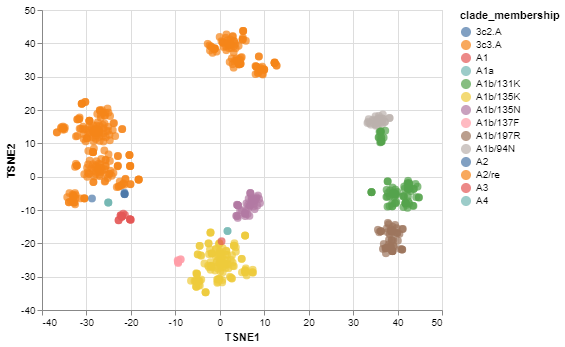

In [43]:
real = scatterplot_with_tooltip_interactive(merged_tsne_df,'TSNE1','TSNE2',"TSNE1","TSNE2",['strain','clade_membership'],'clade_membership')
real

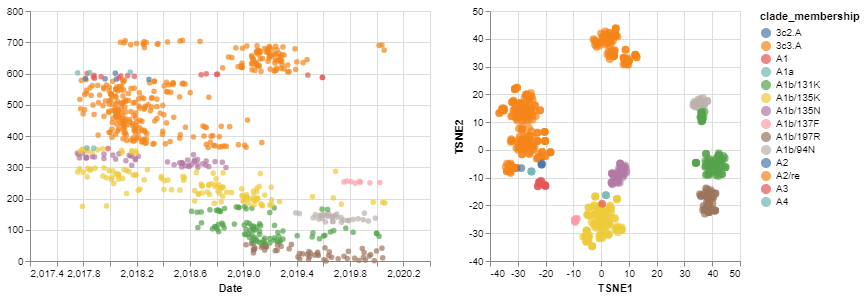

In [44]:
list_of_chart = linking_tree_with_plots_brush(
    merged_tsne_df,
    ['TSNE1','TSNE2'],
    ['TSNE1','TSNE2'],
    'clade_membership',
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

In [45]:
def scatterplot_xyvaluess(strains, similarity_matrix, embedding_df, column1, column2, type_of_embedding):
    """Returns a unraveled similarity matrix Pandas dataframe of pairwise and euclidean distances for each strain pair 
     Parameters
    -----------
    strains: list
        list of strains for the build (ex. A/Oman/5263/2017)
    similarity_matrix: Pandas Dataframe
        a similarity matrix using hamming distance to compare pairwise distance between each strain
    df_merged: Pandas Dataframe
        dataframe containing the euclidean coordinates of each strain in an embedding (PCA, MDS, t-SNE, UMAP)
    column1: string
        the name of the first column in df_merged to compare distance between
    column2: string
        the name of the second column in df_merged to compare distance between
    type_of_embedding: string
        "MDS", "PCA", "TSNE", or "UMAP"
        
    Returns 
    ---------
    A Pandas Dataframe of pairwise and euclidean distances for every strain pair
    """
    pairwise_distance_array = np.array(similarity_matrix)[
        np.triu_indices(len(embedding_df), k=0)]

    indexes_tuple = np.triu_indices(len(embedding_df), k=0)
    row_number = indexes_tuple[0]
    column_number = indexes_tuple[1]
    row_strain = pd.DataFrame([strains[x] for x in row_number])
    column_strain = pd.DataFrame([strains[x] for x in column_number])

    pairwise_df = pd.DataFrame(pairwise_distance_array)
    row_column = row_strain.merge(
        column_strain, how='outer', left_index=True, right_index=True)
    row_column.columns = ["row", "column"]

    distances = pdist(embedding_df[[column1, column2]])
    euclidean_df = pd.DataFrame({"distance": distances})
    euclidean_df["embedding"] = type_of_embedding
    euclidean_df.columns = ["euclidean", "embedding"]
    
    row_column_pairwise = row_column.merge(
        pairwise_df, how='outer', left_index=True, right_index=True)
    row_column_pairwise = row_column_pairwise.where(
        row_column_pairwise["row"] != row_column_pairwise["column"]).dropna().set_index(euclidean_df.index)
    
    total_df = row_column_pairwise.merge(
        euclidean_df, how='inner', left_index=True, right_index=True).dropna()
    total_df.columns = ["row", "column", "genetic",
                        "euclidean", "embedding"]

    return total_df

In [46]:
embedding_df = pd.read_csv("../seasonal-flu-nextstrain/results/embed_tsne.csv", index_col=0)
distance_matrix = pd.read_csv("../seasonal-flu-nextstrain/results/distance_matrix_tsne.csv", index_col=0)

In [47]:
embedding_df

,tsne_x,tsne_y
U26830.1,18.957607,-13.177021
A/Alabama/30/2017,35.381090,-11.047927
A/Florida/84/2017,35.387363,-11.047817
A/NorthDakota/23/2017,35.386364,-11.047289
A/Florida/18/2018,27.858278,-3.489819
...,...,...
A/Ohio/08/2019,5.382043,35.529236
A/Florida/78/2019,0.097180,36.307858
A/California/16/2020,5.817891,43.520447
A/Minnesota/40/2018,2.213254,47.140873


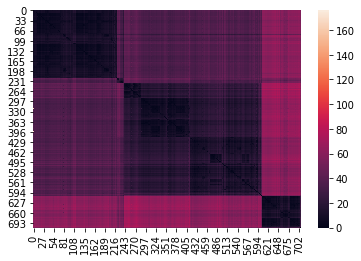

In [48]:
sns.heatmap(distance_matrix)

In [49]:
embedding_df["strain"] = strains
embedding_df = embedding_df.merge(node_df, on="strain")

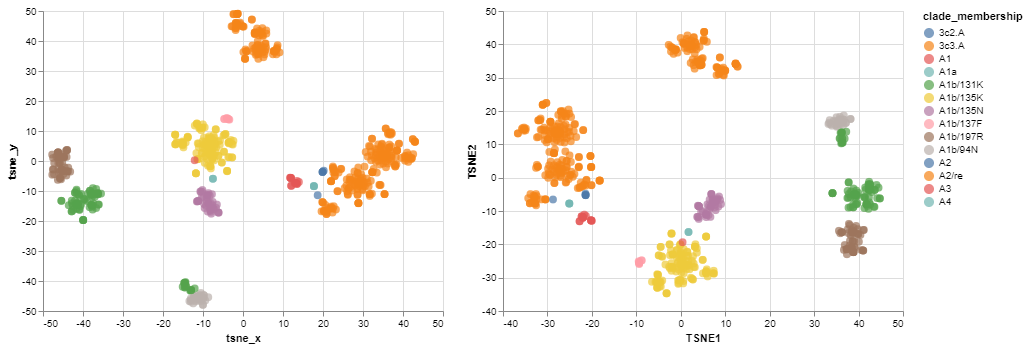

In [50]:
 chart = alt.Chart(embedding_df).mark_circle(size=60).encode(
    x="tsne_x",
    y="tsne_y",
    color = "clade_membership"
 )
chart | real

In [51]:
embedding_df

,tsne_x,tsne_y,strain,date,y,region,country,parent_date,parent_y,clade_membership,clade_membership_color
0,35.381090,-11.047927,A/Alabama/30/2017,2017.921918,531,N,USA,2017.778529,530.500000,A2/re,A2/re
1,35.387363,-11.047817,A/Florida/84/2017,2017.809589,532,N,USA,2017.778529,530.500000,A2/re,A2/re
2,35.386364,-11.047289,A/NorthDakota/23/2017,2017.858904,530,N,USA,2017.778529,530.500000,A2/re,A2/re
3,27.858278,-3.489819,A/Florida/18/2018,2018.083562,548,N,USA,2017.857268,547.000000,A2/re,A2/re
4,25.847332,-8.195424,A/Indiana/31/2017,2017.908219,562,N,USA,2017.625276,538.366642,A2/re,A2/re
...,...,...,...,...,...,...,...,...,...,...,...
702,5.382043,35.529236,A/Ohio/08/2019,2019.127397,647,N,USA,2018.965443,647.000000,3c3.A,3c3.A
703,0.097180,36.307858,A/Florida/78/2019,2019.478082,644,N,USA,2018.963407,640.750000,3c3.A,3c3.A
704,5.817891,43.520447,A/California/16/2020,2020.056011,675,N,USA,2018.730011,675.000000,3c3.A,3c3.A
705,2.213254,47.140873,A/Minnesota/40/2018,2018.543836,706,N,USA,2017.963472,705.000000,3c3.A,3c3.A


In [55]:
total_df = scatterplot_xyvaluess(embedding_df.index, distance_matrix, embedding_df, "tsne_x", "tsne_y", "TSNE")
y_values = statsmodels.nonparametric.smoothers_lowess.lowess(
    total_df["euclidean"],
    total_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

PD_Y_values = pd.DataFrame(y_values)
PD_Y_values.columns = ["LOWESS_x", "LOWESS_y"]

regression = linregress(total_df["genetic"], total_df["euclidean"])
slope, intercept, r_value, p_value, std_err = regression

In [57]:
total_df = scatterplot_xyvaluess(similarity_matrix.index, similarity_matrix, merged_tsne_df, "TSNE1", "TSNE2", "TSNE")
y_values = statsmodels.nonparametric.smoothers_lowess.lowess(
    total_df["euclidean"],
    total_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

PD_Y_values = pd.DataFrame(y_values)
PD_Y_values.columns = ["LOWESS_x", "LOWESS_y"]

regression = linregress(total_df["genetic"], total_df["euclidean"])
slope, intercept, r_value, p_value, std_err = regression

C:\Users\srava\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\srava\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\srava\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


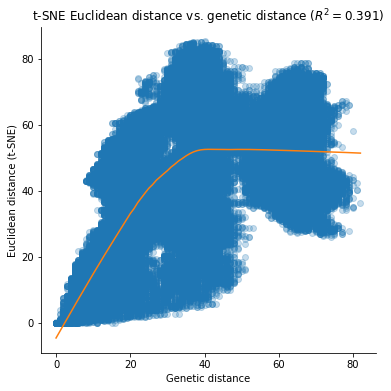

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df["genetic"], total_df["euclidean"], "o", alpha=0.25)
ax.plot(PD_Y_values["LOWESS_x"], PD_Y_values["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (t-SNE)")
ax.set_title("t-SNE Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value ** 2))

sns.despine()
#plt.savefig("docs/TSNEScatterplot" + virus_name + ".png")

In [ ]:
TSNE_violin_df = get_euclidean_data_frame(merged_tsne_df, "TSNE1", "TSNE2", "TSNE")

scaler = StandardScaler()

TSNE_violin_df["scaled_distance"] = scaler.fit_transform(pdist(TSNE_df.drop(["strain"], axis = 1)).reshape(-1, 1))

TSNE_violin_df["genetic_distance"] = squareform(similarity_matrix).reshape(-1, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax = sns.kdeplot(TSNE_violin_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_violin_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

ax = axes[1]
ax = sns.kdeplot(TSNE_violin_df.query("clade_status == 'within'")["genetic_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_violin_df.query("clade_status == 'between'")["genetic_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Genetic distance")
ax.set_ylabel("KDE density")

fig.suptitle('TSNE KDE Plot', fontsize=16)
sns.despine()

# Running UMAP on the Dataset

In [ ]:
reducer = umap.UMAP(n_neighbors=200,
        min_dist=.05,
        n_components=2,
        init="spectral")
X_transformed_umap = reducer.fit_transform(similarity_matrix)

In [ ]:
UMAP_df = pd.DataFrame(X_transformed_umap,columns=['UMAP' + str(i) for i in range(1,3)])

In [ ]:
UMAP_df["strain"] = similarity_matrix.index

In [ ]:
UMAP_df.head()

In [ ]:
merged_umap_df = UMAP_df.merge(node_df, on="strain")

In [ ]:
scatterplot_with_tooltip_interactive(merged_umap_df,'UMAP1','UMAP2',"UMAP1","UMAP2",['strain','clade_membership'],'clade_membership')

In [ ]:
list_of_data_and_titles = ['UMAP1','UMAP2']
list_of_chart = linking_tree_with_plots_brush(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership',
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

In [ ]:
UMAP_violin_df = get_euclidean_data_frame(merged_umap_df, "UMAP1", "UMAP2", "UMAP")

scaler = StandardScaler()

UMAP_violin_df["scaled_distance"] = scaler.fit_transform(pdist(UMAP_df.drop(["strain"], axis = 1)).reshape(-1, 1))

UMAP_violin_df["genetic_distance"] = squareform(similarity_matrix).reshape(-1, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax = sns.kdeplot(UMAP_violin_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_violin_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

ax = axes[1]
ax = sns.kdeplot(UMAP_violin_df.query("clade_status == 'within'")["genetic_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_violin_df.query("clade_status == 'between'")["genetic_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Genetic distance")
ax.set_ylabel("KDE density")

fig.suptitle('UMAP KDE Plot', fontsize=16)
sns.despine()

In [ ]:
total_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_umap_df, "UMAP1", "UMAP2", "UMAP")
y_values = statsmodels.nonparametric.smoothers_lowess.lowess(
    total_df["euclidean"],
    total_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

PD_Y_values = pd.DataFrame(y_values)
PD_Y_values.columns = ["LOWESS_x", "LOWESS_y"]

regression = linregress(total_df["genetic"], total_df["euclidean"])
slope, intercept, r_value, p_value, std_err = regression

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df["genetic"], total_df["euclidean"], "o", alpha=0.25)
ax.plot(PD_Y_values["LOWESS_x"], PD_Y_values["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (UMAP)")
ax.set_title("UMAP Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value ** 2))

sns.despine()
plt.savefig("docs/UMAPScatterplot" + virus_name + ".png")

# Linking all plots together clickable with Tree

In [ ]:
merged_df = node_df.merge(
    principalDf,
    on="strain"
).merge(
    MDS_df,
    on="strain"
).merge(
    TSNE_df,
    on="strain"
).merge(
    UMAP_df,
    on="strain"
)

In [ ]:
merged_df.shape

In [ ]:
merged_df.head()

In [ ]:
data = linking_tree_with_plots_clickable(
    merged_df,
    ['MDS1', 'MDS2','TSNE1', 'TSNE2', 'PCA1', 'PCA2', 'UMAP1', 'UMAP2'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'clade_membership_color:N',
    ['clade_membership'],
    ['strain','clade_membership']
)

In [ ]:
data1 = linking_tree_with_plots_brush(
    merged_df,
    ['TSNE1', 'TSNE2','UMAP1', 'UMAP2'],
    ['TSNE1', 'TSNE2','UMAP1','UMAP2'],
    'clade_membership:N',
    ['strain','clade_membership']
)

In [ ]:
TSNEUMAP = data1[0]|data1[1]|data1[2]
TSNEUMAP.save("docs/TSNEUMAPClickable" + virus_name + ".html")
TSNEUMAP

In [ ]:
PCAMDS = data[3]|data[1]|data[5]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.hconcat(data[0],embeddings)
fullChart
#fullChart.save("docs/FullLinkedChartClickable" + virus_name + ".html")
#fullChart.save("docs/FullLinkedChartClickable" + virus_name + ".svg", scale_factor=2.0)
#drawing = svg2rlg("docs/FullLinkedChartClickable" + virus_name + ".svg")
#renderPDF.drawToFile(drawing, "docs/FullLinkedChartClickable" + virus_name + ".pdf")

## Scatterplots for all embeddings 
Concatenating all embedding data frames to plot genetic vs Euclidean distance for each embedding

In [ ]:
umap_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_umap_df, "UMAP1", "UMAP2", "UMAP")
tsne_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_tsne_df, "TSNE1", "TSNE2", "TSNE")
mds_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_mds_df, "MDS1", "MDS2", "MDS")
pca_df = scatterplot_xyvalues(similarity_matrix.index, similarity_matrix, merged_pca_df, "PCA1", "PCA2", "PCA")

y_values_umap = statsmodels.nonparametric.smoothers_lowess.lowess(
    umap_df["euclidean"],
    umap_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

y_values_tsne = statsmodels.nonparametric.smoothers_lowess.lowess(
    tsne_df["euclidean"],
    tsne_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

y_values_mds = statsmodels.nonparametric.smoothers_lowess.lowess(
    mds_df["euclidean"],
    mds_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

y_values_pca = statsmodels.nonparametric.smoothers_lowess.lowess(
    pca_df["euclidean"],
    pca_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
)

PD_Y_values_umap = pd.DataFrame(y_values_umap)
PD_Y_values_umap.columns = ["LOWESS_x", "LOWESS_y"]

regression_umap = linregress(umap_df["genetic"], umap_df["euclidean"])
slope, intercept, r_value_umap, p_value, std_err = regression_umap

PD_Y_values_tsne = pd.DataFrame(y_values_tsne)
PD_Y_values_tsne.columns = ["LOWESS_x", "LOWESS_y"]

regression_tsne = linregress(tsne_df["genetic"], tsne_df["euclidean"])
slope, intercept, r_value_tsne, p_value, std_err = regression_tsne

PD_Y_values_mds = pd.DataFrame(y_values_mds)
PD_Y_values_mds.columns = ["LOWESS_x", "LOWESS_y"]

regression_mds = linregress(mds_df["genetic"], mds_df["euclidean"])
slope, intercept, r_value_mds, p_value, std_err = regression_mds

PD_Y_values_pca = pd.DataFrame(y_values_pca)
PD_Y_values_pca.columns = ["LOWESS_x", "LOWESS_y"]

regression_pca = linregress(pca_df["genetic"], pca_df["euclidean"])
slope, intercept, r_value_pca, p_value, std_err = regression_pca

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.tight_layout(pad=4.0)

ax1.plot(pca_df["genetic"], pca_df["euclidean"], "o", alpha=0.25)
ax1.plot(PD_Y_values_pca["LOWESS_x"], PD_Y_values_pca["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title("PCA Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value_pca ** 2))

ax2.plot(mds_df["genetic"], mds_df["euclidean"], "o", alpha=0.25)
ax2.plot(PD_Y_values_mds["LOWESS_x"], PD_Y_values_mds["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (MDS)")
ax2.set_title("MDS Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value_mds ** 2))

ax3.plot(tsne_df["genetic"], tsne_df["euclidean"], "o", alpha=0.25)
ax3.plot(PD_Y_values_tsne["LOWESS_x"], PD_Y_values_tsne["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title("t-SNE Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value_tsne ** 2))

ax4.plot(umap_df["genetic"], umap_df["euclidean"], "o", alpha=0.25)
ax4.plot(PD_Y_values_umap["LOWESS_x"], PD_Y_values_umap["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title("UMAP Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value_umap ** 2))


sns.despine()
plt.savefig("docs/FullScatterplot" + virus_name + ".png")

## Within- and between-clade Euclidean distances for all embeddings

Use the complete embedding data frame to calculate pairwise Euclidean distances between samples and plot the results in a single figure.

In [ ]:
scaler = StandardScaler()

fig, axes = plt.subplots(1, 4, figsize=(28, 6))

ax = axes[0]
ax = sns.kdeplot(UMAP_violin_df.query("clade_status == 'within'")["genetic_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_violin_df.query("clade_status == 'between'")["genetic_distance"], label="Different clade", ax=ax)
ax.set_title('genetic')
ax.set_xlabel("Genetic distance")
ax.set_ylabel("KDE density")

#MDS
ax = axes[1]
ax = sns.kdeplot(MDS_violin_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_violin_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)
ax.set_title('MDS')
ax.set_xlabel("Scaled Euclidean distance from embedding (MDS)")
ax.set_ylabel("KDE density")

#TSNE
ax = axes[2]
ax = sns.kdeplot(TSNE_violin_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_violin_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)
ax.set_title('TSNE')
ax.set_xlabel("Scaled Euclidean distance from embedding (TSNE)")
ax.set_ylabel("KDE density")

#UMAP
ax = axes[3]
ax = sns.kdeplot(UMAP_violin_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_violin_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)
ax.set_title('UMAP')
ax.set_xlabel("Scaled Euclidean distance from embedding (UMAP)")
ax.set_ylabel("KDE density")


fig.suptitle('Total KDE Plot', fontsize=16)
sns.despine()

# Supplementary Figures

## UMAP neighbors and distance 

In [ ]:
neighbors = [5, 25, 200]
min_dist = [.05, .5]
X_transformed_umap = []
new_df = []
UMAP_dataframe = pd.DataFrame()
UMAP_dataframe["strain"] = similarity_matrix.index
for i in range(0, len(neighbors)):
    for j in range(0, len(min_dist)):
        reducer = umap.UMAP(n_neighbors=neighbors[i],
        min_dist= min_dist[j],
        n_components=2,
        init="spectral")  
        new_list = pd.DataFrame(reducer.fit_transform(similarity_matrix))
        new_list_df = pd.DataFrame(new_list)
        new_list_df.columns = ['UMAP' + str(i) + str(j) + '_' + str(k) for k in range(1,3)]
        UMAP_dataframe = UMAP_dataframe.join(pd.DataFrame(new_list))  
        new_df = UMAP_dataframe.merge(node_df, on="strain")
        

In [ ]:
new_df

# Across the x axis, the neighbors increases (5, 25, 200)
# From top to bottom, the min dist increases from .05 to .5

In [ ]:
data1 = linking_tree_with_plots_brush(
    new_df,
    ['UMAP00_1',"UMAP00_2", 'UMAP01_1',"UMAP01_2", 'UMAP10_1',"UMAP10_2", 'UMAP11_1',"UMAP11_2", 'UMAP20_1',"UMAP20_2", 'UMAP21_1',"UMAP21_2"],
    ['UMAP00_1',"UMAP00_2", 'UMAP01_1',"UMAP01_2", 'UMAP10_1',"UMAP10_2", 'UMAP11_1',"UMAP11_2", 'UMAP20_1',"UMAP20_2", 'UMAP21_1',"UMAP21_2"],
    'clade_membership_color:N',
    ['strain','clade_membership']
)
top_row = data1[2].properties(title = "UMAP Neighbors = 5, min dist = .05")|data1[4].properties(title = "UMAP Neighbors = 25, min dist = .05")|data1[6].properties(title = "UMAP Neighbors = 200, min dist = .05")
bottom_row = data1[1].properties(title = "UMAP Neighbors = 5, min dist = .5")|data1[3].properties(title = "UMAP Neighbors = 25, min dist = .5")|data1[5].properties(title = "UMAP Neighbors = 200, min dist = .5")
total = alt.vconcat(top_row, bottom_row)
total = alt.hconcat(data1[0], total)
total
total.save("docs/UMAP_neighbors_mindist_chart_" + virus_name + ".html")
total.save("docs/UMAP_neighbors_mindist_chart_" + virus_name + ".svg", scale_factor=2.0)
drawing = svg2rlg("docs/UMAP_neighbors_mindist_chart_" + virus_name + ".svg")
renderPDF.drawToFile(drawing, "docs/UMAP_neighbors_mindist_chart_" + virus_name + ".pdf")

In [ ]:
learning_rate = [100.0, 200.0, 300.0, 400.0, 500.0, 1000.0]
new_df = []
new_list_df = []
TSNE_dataframe = pd.DataFrame()
TSNE_dataframe["strain"] = similarity_matrix.index
for i in range (0, len(learning_rate)):
    embedding = TSNE(n_components=2,metric='precomputed',learning_rate=learning_rate[i],perplexity = 25.95)
    X_transformed = pd.DataFrame(embedding.fit_transform(similarity_matrix))
    new_list_df = pd.DataFrame(X_transformed)
    new_list_df.columns = ['TSNE' + str(i) + '_' + str(k) for k in range(1,3)]
    TSNE_dataframe = TSNE_dataframe.join(pd.DataFrame(new_list_df))  
    new_df = TSNE_dataframe.merge(node_df, on="strain")

In [ ]:
new_df

In [ ]:
data1 = linking_tree_with_plots_brush(
    new_df,
    ["TSNE0_1", "TSNE0_2", "TSNE1_1", "TSNE1_2", "TSNE2_1", "TSNE2_2", "TSNE3_1", "TSNE3_2", "TSNE4_1", "TSNE4_2", "TSNE5_1", "TSNE5_2"],
    ["TSNE0_1", "TSNE0_2", "TSNE1_1", "TSNE1_2", "TSNE2_1", "TSNE2_2", "TSNE3_1", "TSNE3_2", "TSNE4_1", "TSNE4_2", "TSNE5_1", "TSNE5_2"],
    'clade_membership_color:N',
    ['strain','clade_membership']
)
top_row = data1[1].properties(title = "TSNE learning rate = 100.0")|data1[2].properties(title = "TSNE learning rate = 200.0 (default)")|data1[3].properties(title = "TSNE learning rate = 300.0")
bottom_row = data1[4].properties(title = "TSNE learning rate = 400.0")|data1[5].properties(title = "TSNE learning rate = 500.0")|data1[6].properties(title = "TSNE learning rate = 1000.0")
total = alt.vconcat(top_row, bottom_row)
total = alt.hconcat(data1[0], total)
total
total.save("docs/TSNELearningRates" + virus_name + ".html")
total.save("docs/TSNELearningRates" + virus_name + ".svg", scale_factor=2.0)
drawing = svg2rlg("docs/TSNELearningRates" + virus_name + ".svg")
renderPDF.drawToFile(drawing, "docs/TSNELearningRates" + virus_name + ".pdf")

In [ ]:
perplexity = [15, 20, 25, 30, 100]
new_df = []
new_list_df = []
TSNE_dataframe = pd.DataFrame()
TSNE_dataframe["strain"] = similarity_matrix.index
for i in range (0, len(perplexity)):
    embedding = TSNE(n_components=2,metric='precomputed', perplexity = perplexity[i])
    X_transformed = pd.DataFrame(embedding.fit_transform(similarity_matrix))
    new_list_df = pd.DataFrame(X_transformed)
    new_list_df.columns = ['TSNE' + str(i) + '_' + str(k) for k in range(1,3)]
    TSNE_dataframe = TSNE_dataframe.join(pd.DataFrame(new_list_df))  
    new_df = TSNE_dataframe.merge(node_df, on="strain")

In [ ]:
data1 = linking_tree_with_plots_brush(
    new_df,
    ["TSNE0_1", "TSNE0_2", "TSNE1_1", "TSNE1_2", "TSNE2_1", "TSNE2_2", "TSNE3_1", "TSNE3_2", "TSNE4_1", "TSNE4_2"],
    ["TSNE0_1", "TSNE0_2", "TSNE1_1", "TSNE1_2", "TSNE2_1", "TSNE2_2", "TSNE3_1", "TSNE3_2", "TSNE4_1", "TSNE4_2"],
    'clade_membership_color:N',
    ['strain','clade_membership']
)
top_row = data1[1].properties(title = "TSNE perplexity = 15")|data1[2].properties(title = "TSNE perplexity = 20")|data1[3].properties(title = "TSNE perplexity = 25")
bottom_row = data1[4].properties(title = "TSNE perplexity = 30")|data1[5].properties(title = "TSNE perplexity = 100")
total = alt.vconcat(top_row, bottom_row)
total = alt.hconcat(data1[0], total)
total
total.save("docs/TSNEPerplexity" + virus_name + ".html")
chart.save("docs/TSNEPerplexity" + virus_name + ".svg", scale_factor=2.0)
drawing = svg2rlg("docs/TSNEPerplexity" + virus_name + ".svg")
renderPDF.drawToFile(drawing, "docs/TSNEPerplexity" + virus_name + ".pdf")